### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 26th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.interpolate import interp1d

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Part 1.1

In [2]:
datadir = '../../../homeworks/hw_data/'
rawdata = np.load(datadir+'hw4_data_1.npy')

In [3]:
data1 = rawdata[:,0]
sig1 = rawdata[:,1]
print(data1,sig1,'\n')

#Compute the sample mean
mean = np.average(data1,weights=1/np.square(sig1))
print(f'Sample Mean: {mean}')

uncert = 1/np.sqrt(np.sum(1/np.square(sig1)))
print(f'Uncertainty in sample mean: {uncert}')

[4.36 4.   4.87 5.64 6.14 5.92 3.93 6.58 3.78 5.84] [2.24 1.94 1.39 2.55 1.69 1.38 1.   1.6  1.   1.  ] 

Sample Mean: 4.942118214425304
Uncertainty in sample mean: 0.43024334605205083


### Part 1.2

Assume gaussian errors around true voltage. Use the following log-likelihood function

$$ ln(p) = \sum_i^N ln\left(\frac{1}{\sqrt{2 \pi \sigma_i^2}}\right) - \sum_i^N \left( \frac{(y_i - \mu)^2}{2 \sigma_i^2} \right) $$

In [4]:
#Use gaussian likelihood
def ln_gaussian1(x,data,datasig):
    mu = x[0]
    ss = np.square(datasig)
    return np.sum( np.log(1/np.sqrt(2*np.pi*ss)) ) - np.sum( np.square(data-mu)/(2*ss))

def neg_ln_gaussian1(x,data=data1,datasig=sig1):
    return -ln_gaussian1(x,data,datasig)

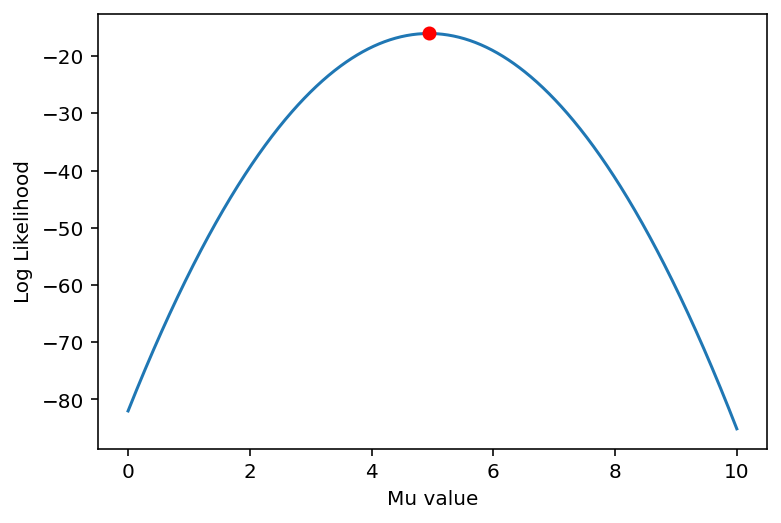

Maximized likelihood mu: 4.942118238236665


In [5]:
#Use scipy's minimize function and plot it to see that it got it correctly

optMu = minimize(neg_ln_gaussian1,[0]).x[0]

mu_vals = np.linspace(0,10,1000)
lnlike = [ln_gaussian1([mu],data1,sig1) for mu in mu_vals]

plt.plot(mu_vals,lnlike,label='Log likelihood surface')
plt.plot(optMu,ln_gaussian1([optMu],data1,sig1),'or',label='Best fit')
plt.xlabel('Mu value')
plt.ylabel('Log Likelihood')
plt.show()
print(f'Maximized likelihood mu: {optMu}')

### Part 1.3
Using a uniform prior (must be normalized), calculate the posterior using the following:

$$p(\mu|x,\sigma) = \frac{p(x,\sigma|\mu)p(\mu)}{p(x,\sigma)} = \frac{p(x,\sigma|\mu)p(\mu)}{\int p(x,\sigma|\mu)p(\mu) d\mu}$$

You can estimate the integral on the bottom using a Riemann sum if the grid of points is dense.

In [6]:
def prior1(mu):
    #Uniform on range (3-7)
    if mu>=3 and mu<=7:
        return 1/(7-3)
    else:
        return 0

SRT: Yep. For many more parameters, you could vectorize this and save some trouble by using the standard scipy routine.

Ensuring normalized posterior integrates to 1: 1.0000000000000002


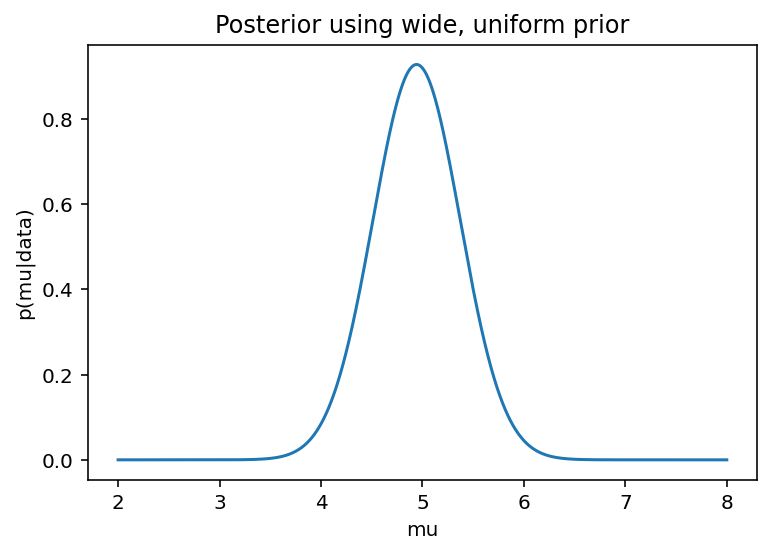

In [7]:
mu_vals = np.linspace(2,8,10000)
dMu = mu_vals[1]-mu_vals[0]

posterior = [np.exp(ln_gaussian1([mu],data1,sig1))*prior1(mu) for mu in mu_vals]
posterior /= (dMu*np.sum(posterior))

print(f'Ensuring normalized posterior integrates to 1: {np.sum(posterior)*dMu}')
plt.plot(mu_vals,posterior)
plt.title('Posterior using wide, uniform prior')
plt.ylabel('p(mu|data)')
plt.xlabel('mu')
plt.show()

SRT: Very good work.

### Part 1.4

#### Wide, uniform prior

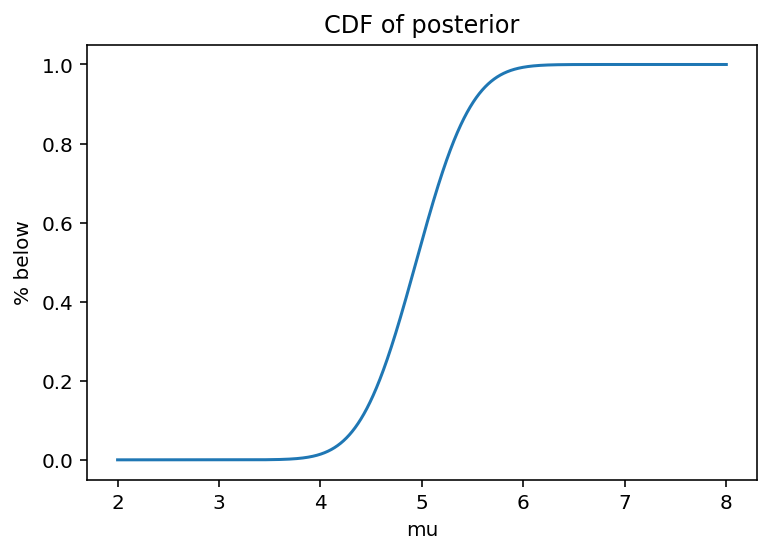

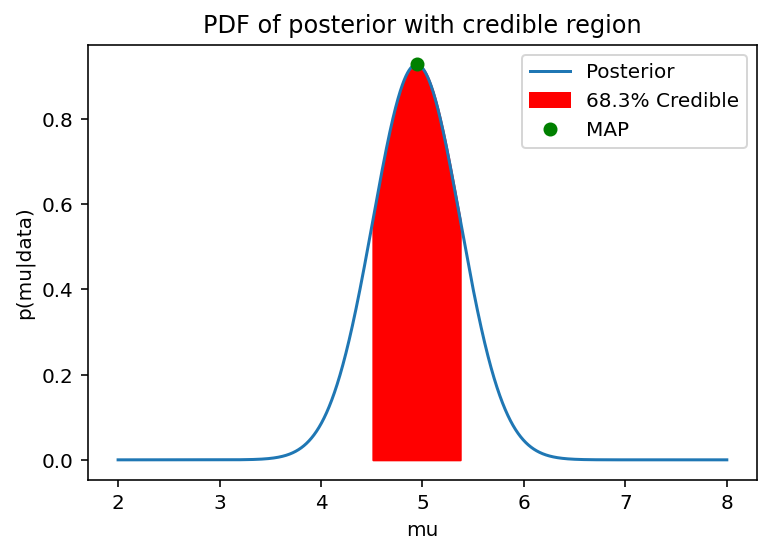

Lower bound on 68.3%: 4.5113032164244 vs Mean-Uncertainty: 4.511874868373253
Upper bound on 68.3%: 5.372337242740368 vs Mean+Uncertainty: 5.372361560477355
Maximum a posteriori value: 4.942094209420942


In [8]:
pdfCumsum = np.cumsum(posterior)*dMu
plt.plot(mu_vals,pdfCumsum)
plt.title('CDF of posterior')
plt.xlabel('mu')
plt.ylabel('% below')
plt.show()

pdf = interp1d(mu_vals,posterior)
cdf = interp1d(pdfCumsum,mu_vals)

#Since we want 68.3% region, thats 68.3%/2 above and below 50% region
lowRegion = cdf(0.5-(.683/2))
highRegion = cdf(0.5+(.683/2))

plt.plot(mu_vals,pdf(mu_vals),label='Posterior')
mu_sub = np.linspace(lowRegion,highRegion,100)
plt.fill_between(mu_sub,pdf(mu_sub),color='r',label='68.3% Credible')
plt.title('PDF of posterior with credible region')
plt.xlabel('mu')
plt.ylabel('p(mu|data)')

iMax = np.argmax(posterior) #Technically just an estimate due to numerical technique
plt.plot(mu_vals[iMax],pdf(mu_vals[iMax]),'go',label='MAP')
plt.legend(loc='upper right')
plt.show()
#Should be accurate to within (8-2)/10000 = 0.0006 ~ 0.001

print(f'Lower bound on 68.3%: {lowRegion} vs Mean-Uncertainty: {mean-uncert}')
print(f'Upper bound on 68.3%: {highRegion} vs Mean+Uncertainty: {mean+uncert}')

print(f'Maximum a posteriori value: {mu_vals[iMax]}')

SRT: Awesome.

### Part 1.5

#### Thin, uniform prior

In [9]:
def prior2(mu):
    if mu>=4.6 and mu<=5.4:
        return 1/(5.4-4.6)
    else:
        return 0

Ensuring normalized posterior integrates to 1: 1.0


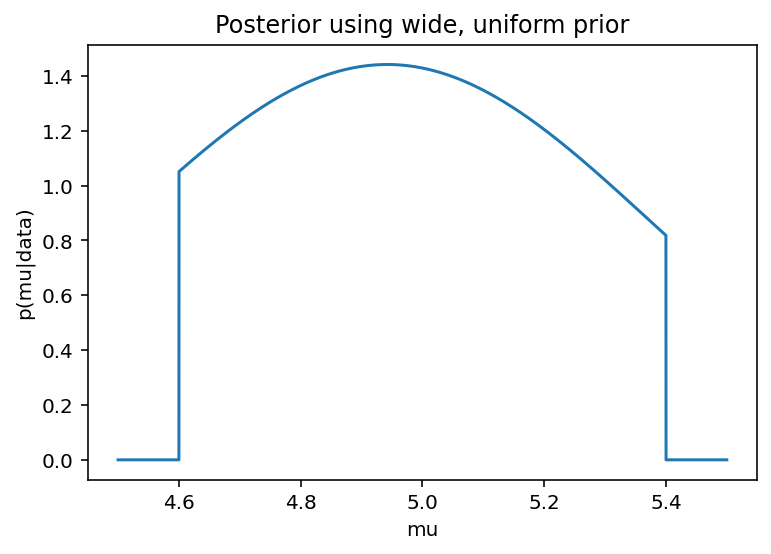

In [10]:
mu_vals = np.linspace(4.5,5.5,10000)
dMu = mu_vals[1]-mu_vals[0]

posterior = [np.exp(ln_gaussian1([mu],data1,sig1))*prior2(mu) for mu in mu_vals]
posterior /= (dMu*np.sum(posterior))

print(f'Ensuring normalized posterior integrates to 1: {np.sum(posterior)*dMu}')
plt.plot(mu_vals,posterior)
plt.title('Posterior using wide, uniform prior')
plt.ylabel('p(mu|data)')
plt.xlabel('mu')
plt.show()

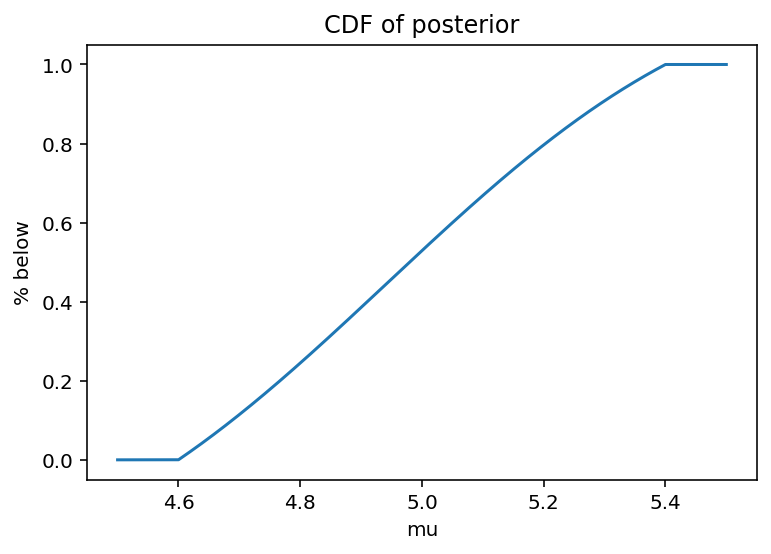

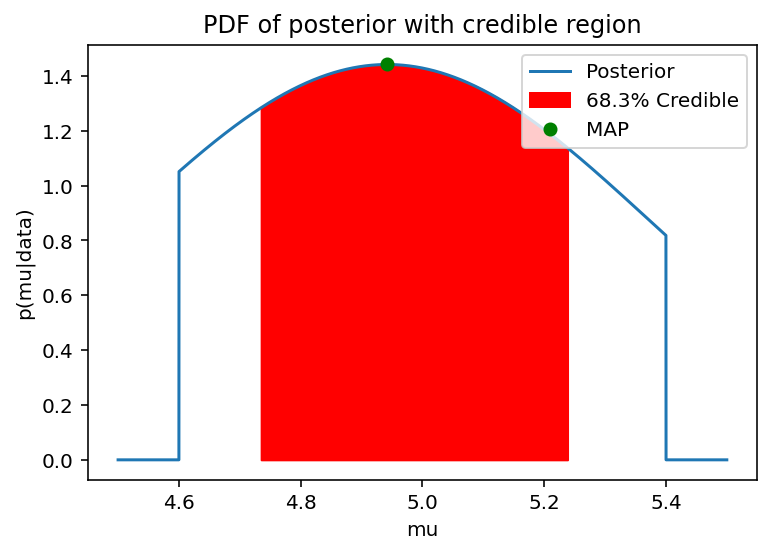

Lower bound on 68.3%: 4.7350185173755825 vs Mean-Uncertainty: 4.511874868373253
Upper bound on 68.3%: 5.238339339571681 vs Mean+Uncertainty: 5.372361560477355
Maximum a posteriori value: 4.942144214421442


In [11]:
pdfCumsum = np.cumsum(posterior)*dMu
plt.plot(mu_vals,pdfCumsum)
plt.title('CDF of posterior')
plt.xlabel('mu')
plt.ylabel('% below')
plt.show()

pdf = interp1d(mu_vals,posterior)
cdf = interp1d(pdfCumsum,mu_vals)

#Since we want 68.3% region, thats 68.3%/2 above and below 50% region
lowRegion = cdf(0.5-(.683/2))
highRegion = cdf(0.5+(.683/2))

plt.plot(mu_vals,pdf(mu_vals),label='Posterior')
mu_sub = np.linspace(lowRegion,highRegion,100)
plt.fill_between(mu_sub,pdf(mu_sub),color='r',label='68.3% Credible')
plt.title('PDF of posterior with credible region')
plt.xlabel('mu')
plt.ylabel('p(mu|data)')

iMax = np.argmax(posterior) #Technically just an estimate due to numerical technique
plt.plot(mu_vals[iMax],pdf(mu_vals[iMax]),'go',label='MAP')
plt.legend(loc='upper right')
plt.show()
#Should be accurate to within (8-2)/10000 = 0.0006 ~ 0.001

print(f'Lower bound on 68.3%: {lowRegion} vs Mean-Uncertainty: {mean-uncert}')
print(f'Upper bound on 68.3%: {highRegion} vs Mean+Uncertainty: {mean+uncert}')

print(f'Maximum a posteriori value: {mu_vals[iMax]}')

SRT: Great work.

### Part 1.5

#### Gaussian prior

In [12]:
normalDist = norm(loc=6,scale=0.3)
def prior3(mu):
    return normalDist.pdf(mu)

Ensuring normalized posterior integrates to 1: 0.9999999999999999


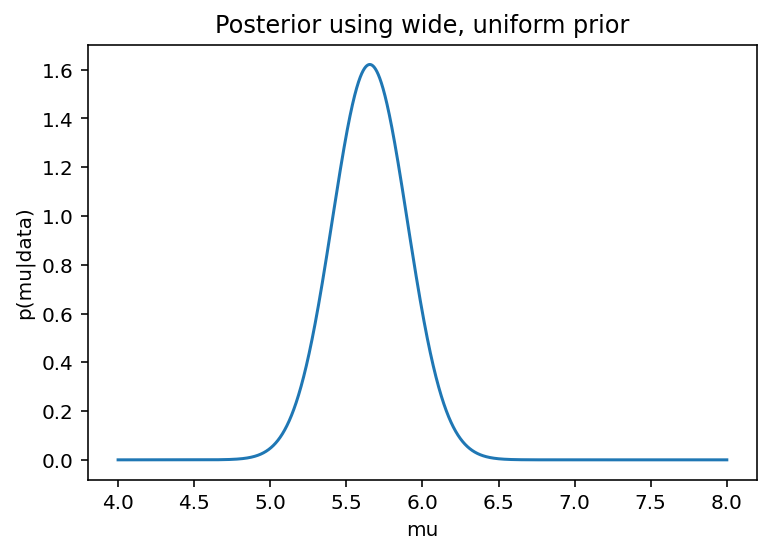

In [13]:
mu_vals = np.linspace(4,8,10000)
dMu = mu_vals[1]-mu_vals[0]

posterior = [np.exp(ln_gaussian1([mu],data1,sig1))*prior3(mu) for mu in mu_vals]
posterior /= (dMu*np.sum(posterior))

print(f'Ensuring normalized posterior integrates to 1: {np.sum(posterior)*dMu}')
plt.plot(mu_vals,posterior)
plt.title('Posterior using wide, uniform prior')
plt.ylabel('p(mu|data)')
plt.xlabel('mu')
plt.show()

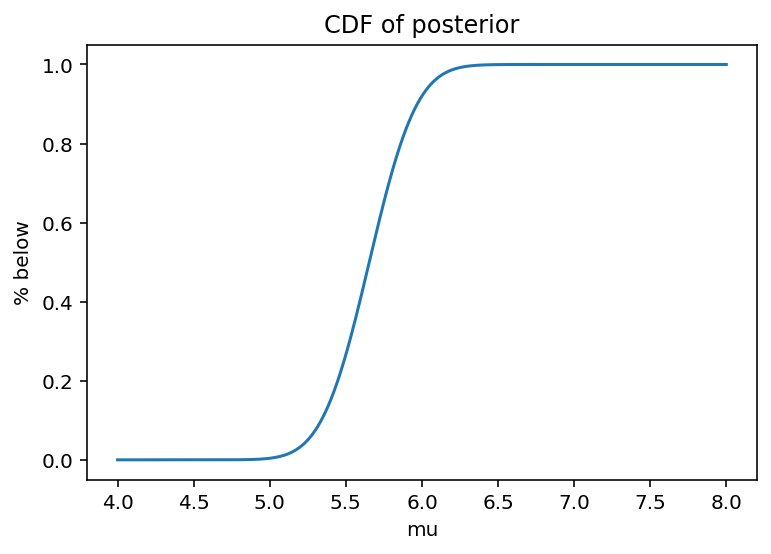

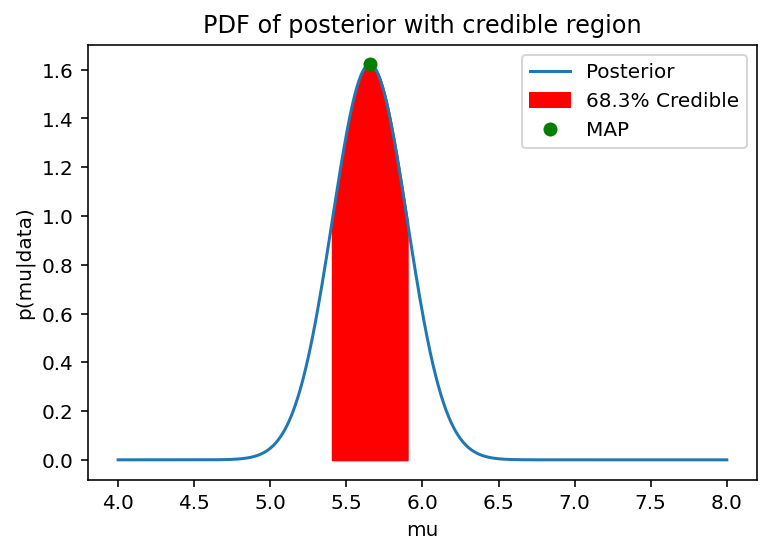

Lower bound on 68.3%: 5.4074800836255985 vs Mean-Uncertainty: 4.511874868373253
Upper bound on 68.3%: 5.899963361660339 vs Mean+Uncertainty: 5.372361560477355
Maximum a posteriori value: 5.653765376537654


In [14]:
pdfCumsum = np.cumsum(posterior)*dMu
plt.plot(mu_vals,pdfCumsum)
plt.title('CDF of posterior')
plt.xlabel('mu')
plt.ylabel('% below')
plt.show()

pdf = interp1d(mu_vals,posterior)
cdf = interp1d(pdfCumsum,mu_vals)

#Since we want 68.3% region, thats 68.3%/2 above and below 50% region
lowRegion = cdf(0.5-(.683/2))
highRegion = cdf(0.5+(.683/2))

plt.plot(mu_vals,pdf(mu_vals),label='Posterior')
mu_sub = np.linspace(lowRegion,highRegion,100)
plt.fill_between(mu_sub,pdf(mu_sub),color='r',label='68.3% Credible')
plt.title('PDF of posterior with credible region')
plt.xlabel('mu')
plt.ylabel('p(mu|data)')

iMax = np.argmax(posterior) #Technically just an estimate due to numerical technique
plt.plot(mu_vals[iMax],pdf(mu_vals[iMax]),'go',label='MAP')
plt.legend(loc='upper right')
plt.show()
#Should be accurate to within (8-2)/10000 = 0.0006 ~ 0.001

print(f'Lower bound on 68.3%: {lowRegion} vs Mean-Uncertainty: {mean-uncert}')
print(f'Upper bound on 68.3%: {highRegion} vs Mean+Uncertainty: {mean+uncert}')

print(f'Maximum a posteriori value: {mu_vals[iMax]}')

### Part 1.7
Plotting all normalized posteriors

In [15]:
mu_vals=np.linspace(0,10,100000)
dMu = mu_vals[1]-mu_vals[0]

post1 = np.array([np.exp(ln_gaussian1([mu],data1,sig1))*prior1(mu) for mu in mu_vals])
post1/= (dMu*np.sum(post1))

post2 = np.array([np.exp(ln_gaussian1([mu],data1,sig1))*prior2(mu) for mu in mu_vals])
post2/= (dMu*np.sum(post2))

post3 = np.array([np.exp(ln_gaussian1([mu],data1,sig1))*prior3(mu) for mu in mu_vals])
post3/= (dMu*np.sum(post3))

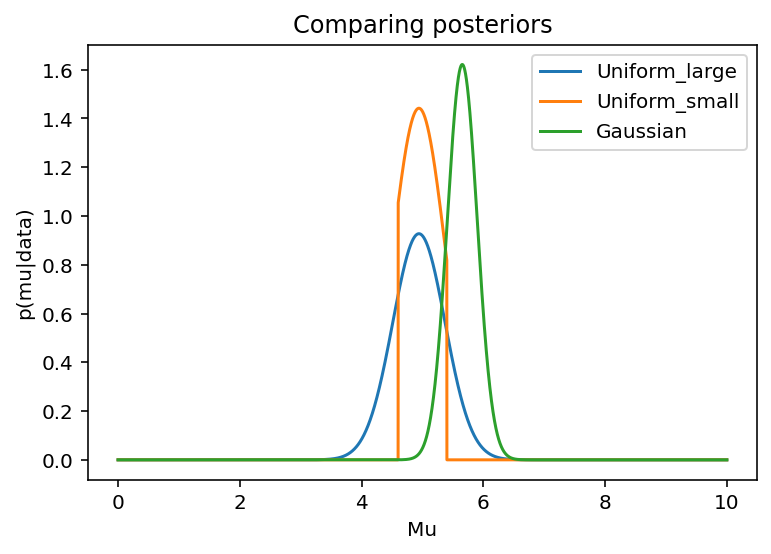

In [16]:
plt.plot(mu_vals,post1,label='Uniform_large')
plt.plot(mu_vals,post2,label='Uniform_small')
plt.plot(mu_vals,post3,label='Gaussian')
plt.legend(loc='upper right')
plt.title('Comparing posteriors')
plt.xlabel('Mu')
plt.ylabel('p(mu|data)')
plt.show()

SRT: Excellent.

### Part 1.8
Delta function & Evidence

if $p(\mu) = \delta(\mu-\bar{\mu})$ then...
$$\int p(x,\sigma|\mu)p(\mu) d\mu = \int p(x,\sigma|\mu)\,\delta(\mu-\bar{\mu}) d\mu =
p(x,\sigma|\bar{\mu})$$

In [17]:
#Evidence for a delta function prior is just the likelihood evaluated at the point
evi_deltaPrior = np.exp(ln_gaussian1([mean],data=data1,datasig=sig1))

#Evidence for other models
evi_LargeUniform = np.sum([np.exp(ln_gaussian1([mu],data1,sig1))*prior1(mu) for mu in mu_vals])*dMu

evi_SmallUniform = np.sum([np.exp(ln_gaussian1([mu],data1,sig1))*prior2(mu) for mu in mu_vals])*dMu

evi_Gaussian     = np.sum([np.exp(ln_gaussian1([mu],data1,sig1))*prior3(mu) for mu in mu_vals])*dMu

In [18]:
print('Evidence for each model:',evi_deltaPrior,evi_LargeUniform,evi_SmallUniform,evi_Gaussian)
print(f'Largest evidence is the delta function prior: {evi_deltaPrior}\n')

#Compute Bayes factors for this model
print(f'Bayes factor (DeltaPrior/LargeUniform): {evi_deltaPrior/evi_LargeUniform}')
print(f'Bayes factor (DeltaPrior/SmallUniform): {evi_deltaPrior/evi_SmallUniform}')
print(f'Bayes factor (DeltaPrior/Gaussian): {evi_deltaPrior/evi_Gaussian}')

Evidence for each model: 1.0725971348964463e-07 2.891871438160117e-08 9.29940527267963e-08 1.1509794016898819e-08
Largest evidence is the delta function prior: 1.0725971348964463e-07

Bayes factor (DeltaPrior/LargeUniform): 3.709006979849907
Bayes factor (DeltaPrior/SmallUniform): 1.1534040118109368
Bayes factor (DeltaPrior/Gaussian): 9.3189950517068


#### Discussion

Using the following image for reference (Lecture 9):
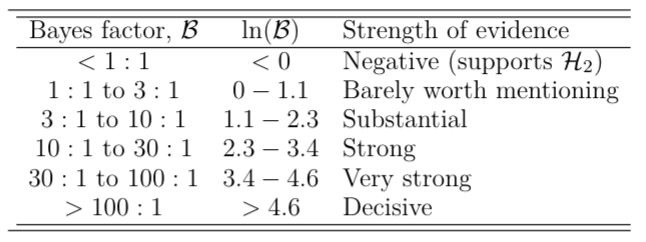
With the Bayesian evidence for each prior, the prior that showed the largest evidence was the delta function prior. Comparing evidences to get Bayes factors for each shows that the delta function has only slightly more evidence over the small uniform prior, while it is decisively more informative than the large uniform prior and majorly informative over the gaussian. Considering the model is the same, the data is more informative if the priors are thin. While I'm not entirely sure what this is saying, I believe that the the data becomes more informative with a well constrained prior. If the prior is well constrained, new data that refutes that is more powerful than data which falls into a larger gaussian prior.

SRT: Yes, you're circling around the right idea. With a wide and weakly-informative prior, the evidence calculation is integrating over a lot of wasted parameter space, resulting in a lower eviedence than a more compact model like the delta-function prior one.

---

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in the lecture. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [19]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

### Solution

### Part 2.1

In [20]:
rawdata2 = np.load(datadir+'hw4_data_2.npy')
xdata = rawdata2[0]
ydata = rawdata2[1]
ysigma = rawdata2[2]

### Part 2.2

In [21]:
def uniPrior1(m):
    if m>=0.5 and m<=1.5:
        return 1/(1.5-0.5)
    else:
        return 0

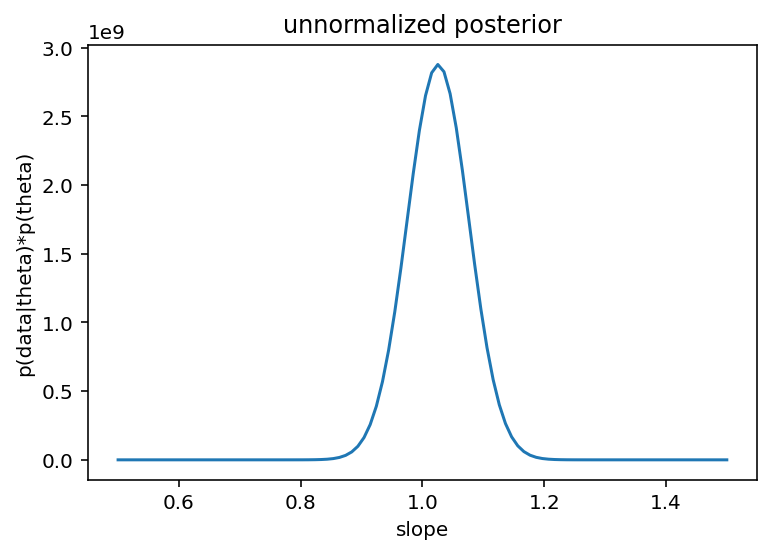

In [22]:
#Fixed y intercept
yInt=-0.23
mGrid = np.linspace(0.5,1.5,100)
dm = mGrid[1]-mGrid[0]

unNormedPost = np.array([np.exp(logL([yInt,m],rawdata2))*uniPrior1(m) for m in mGrid])
plt.plot(mGrid,unNormedPost)
plt.title('unnormalized posterior')
plt.ylabel('p(data|theta)*p(theta)')
plt.xlabel('slope')
plt.show()

### Part 2.3

In [23]:
evi_mod1 = np.sum(unNormedPost)*dm
print(f'Bayesian evidence: {evi_mod1}')

Bayesian evidence: 365684733.1606578


SRT: Good.

### Part 2.4

In [24]:
def uniPrior2(a):
    if a>=-1 and a<=0.25:
        return 1/(0.25+1)
    else:
        return 0

In [25]:
aGrid = np.linspace(-1,0.25,100)
da = aGrid[1]-aGrid[0]
postVals = np.zeros((100,100))

#For every combo of mGrid and aGrid, calculate unnormalized posterior value
for i,m in enumerate(mGrid):
    if i%10==0 and i!=0:
        print(f'{i/len(mGrid) * 100}% complete')
    for j,a in enumerate(aGrid):
        postVals[i,j] = np.exp(logL([yInt,m,a],rawdata2))*uniPrior1(m)*uniPrior2(a)
        
print('Done')

10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
Done


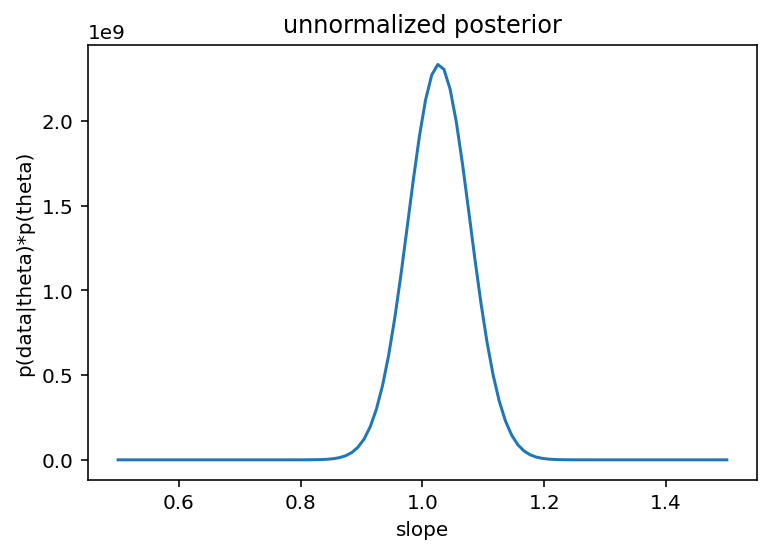

In [26]:
### Just a check

#To check if its right, Check the shape of the posterior near the a=0 line, scale will be different 
#due to prior on quadratic
plt.plot(mGrid,postVals[:,np.argmin(np.abs(aGrid))])
plt.title('unnormalized posterior')
plt.ylabel('p(data|theta)*p(theta)')
plt.xlabel('slope')
plt.show()

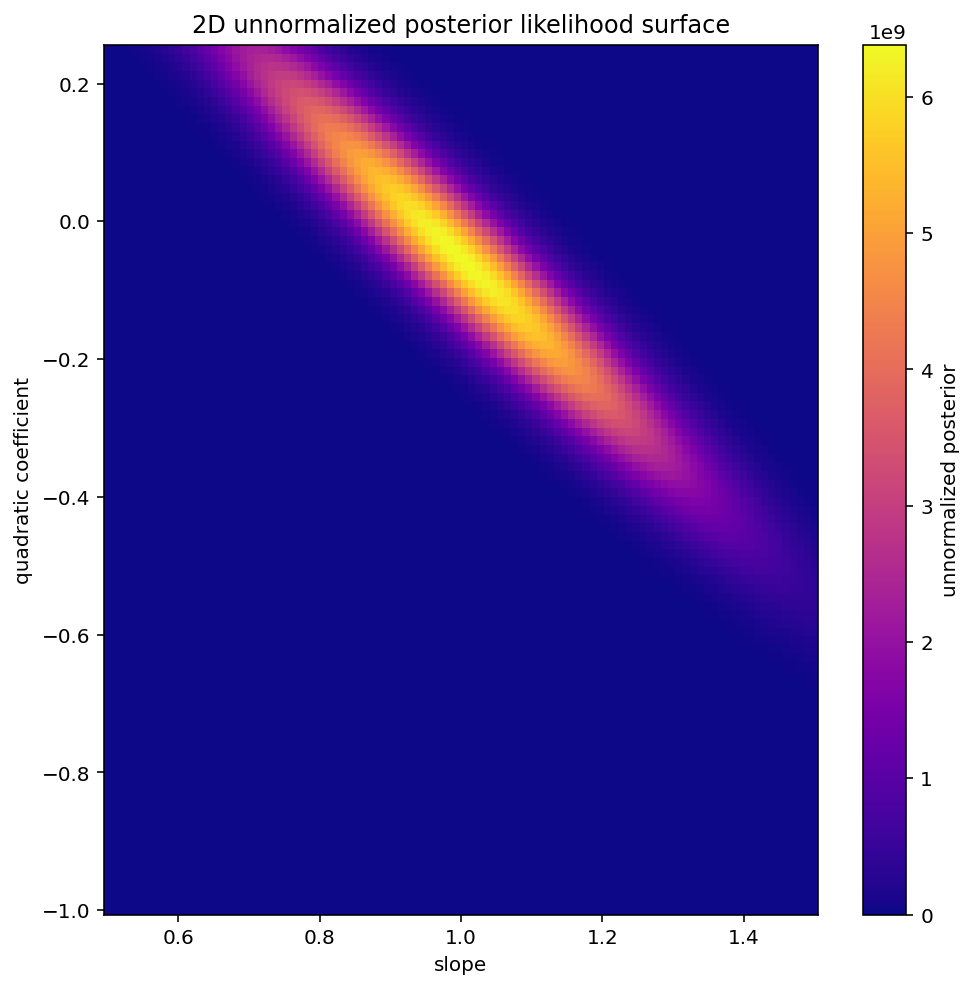

In [27]:
plt.figure(figsize=(8,8))
plt.pcolormesh(mGrid,aGrid,postVals,shading='auto',cmap='plasma')
plt.colorbar(label='unnormalized posterior')
plt.title('2D unnormalized posterior likelihood surface')
plt.xlabel('slope')
plt.ylabel('quadratic coefficient')
plt.show()

### Part 2.5

In [28]:
#Numpy sum will, by default, sum over all dimensions. Just multiply by separations between points
evi_mod2 = np.sum(postVals)*dm*da
print(f'Bayesian evidence for quadratic: {evi_mod2}')

Bayesian evidence for quadratic: 493061001.65705675


### Part 2.6

In [29]:
bayesFactor = evi_mod2/evi_mod1
print(f'Bayes factor for quadratic model vs linear {bayesFactor}')

Bayes factor for quadratic model vs linear 1.3483226313427696


In this case, there is a 'substantial' preference towards the quadratic model over the linear model. However, with the information from lecture 9, we calculated the Bayesian Information Criterion (BIC) where the linear model's BIC of 17.31 fit the data better than the quadratic's 18.45. While I can't exactly explain how this discrepancy arose, I can hypothesize that it may be due to the BIC peanalizing unconstrained parameters and the fact that that BIC was calulated using a variable y intercept.

SRT: Excellent work. Yes, the BIC was penalizing the quadratic parameter more than was warranted according to the full evidence calculation.